# Data Mining Project 
Ahmed - F2300082

Duha - A01193

Sayera - F2300198

In [330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [331]:
# Load all datasets
transactions = pd.read_csv('Input/transactions_2019data.csv')
cards = pd.read_csv('Input/cards_data.csv')
users = pd.read_csv('Input/users_data.csv')

# Load fraud labels
with open('Input/fraud_labels.json', 'r') as f:
    fraud_labels = json.load(f)

# Convert fraud labels to DataFrame for easier merging
fraud_df = pd.DataFrame(fraud_labels)
fraud_df.rename(columns={'fraud': 'is_fraud'}, inplace=True)
fraud_df['is_fraud'] = fraud_df['is_fraud'].map({'Yes': 1, 'No': 0})

print("Data loaded successfully!")
print(f"Transactions shape: {transactions.shape}")
print(f"Cards shape: {cards.shape}")
print(f"Users shape: {users.shape}")
print(f"Fraud labels shape: {fraud_df.shape}")

Data loaded successfully!
Transactions shape: (1159966, 12)
Cards shape: (6146, 13)
Users shape: (2000, 14)
Fraud labels shape: (777339, 2)


# Part 1: Exploratory Data Analysis (EDA)

## Objective
Understand the dataset and identify initial patterns or anomalies.


## 1. Data Overview

### 1.1 Dataset Description

This section describes the dataset structure: number of rows, columns, types of variables, and memory usage.


In [332]:
# Merge fraud labels with transactions
transactions_with_fraud = transactions.merge(fraud_df, left_on='id', right_on='transaction_id', how='left')
transactions_with_fraud['is_fraud'] = transactions_with_fraud['is_fraud'].fillna(0).astype(int)

# Merge all datasets for comprehensive analysis
# First merge transactions with cards
# Note: transactions has 'card_id', cards has 'id'
df_merged = transactions_with_fraud.merge(cards, left_on='card_id', right_on='id', how='left', suffixes=('_trans', '_card'))

# Then merge with users
# Note: After first merge, 'client_id' from transactions becomes 'client_id_trans' due to suffixes
df_merged = df_merged.merge(users, left_on='client_id_trans', right_on='id', how='left', suffixes=('', '_user'))

print("Merged dataset shape:", df_merged.shape)
print("\nDataset Overview:")
print("=" * 50)


Merged dataset shape: (1159966, 41)

Dataset Overview:


In [333]:
# 1. TRANSACTIONS DATASET
print("1. TRANSACTIONS DATASET")
print("-" * 50)
print(f"Shape: {transactions.shape[0]:,} rows × {transactions.shape[1]} columns")
print(f"\nColumns: {list(transactions.columns)}")
print(f"\nData types:\n{transactions.dtypes}")
print(f"\nMemory usage: {transactions.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n" + "=" * 50)


1. TRANSACTIONS DATASET
--------------------------------------------------
Shape: 1,159,966 rows × 12 columns

Columns: ['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors']

Data types:
id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object

Memory usage: 415.04 MB



In [334]:
# Missing values for TRANSACTIONS DATASET
print("Missing values - TRANSACTIONS DATASET")
print("-" * 50)
print(transactions.isnull().sum())


Missing values - TRANSACTIONS DATASET
--------------------------------------------------
id                      0
date                    0
client_id               0
card_id                 0
amount                  0
use_chip                0
merchant_id             0
merchant_city           0
merchant_state     141071
zip                150932
mcc                     0
errors            1141312
dtype: int64


In [335]:
# 2. CARDS DATASET
print("2. CARDS DATASET")
print("-" * 50)
print(f"Shape: {cards.shape[0]:,} rows × {cards.shape[1]} columns")
print(f"\nColumns: {list(cards.columns)}")
print(f"\nData types:\n{cards.dtypes}")
print(f"\nMemory usage: {cards.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n" + "=" * 50)


2. CARDS DATASET
--------------------------------------------------
Shape: 6,146 rows × 13 columns

Columns: ['id', 'client_id', 'card_brand', 'card_type', 'card_number', 'expires', 'cvv', 'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date', 'year_pin_last_changed', 'card_on_dark_web']

Data types:
id                        int64
client_id                 int64
card_brand               object
card_type                object
card_number               int64
expires                  object
cvv                       int64
has_chip                 object
num_cards_issued          int64
credit_limit             object
acct_open_date           object
year_pin_last_changed     int64
card_on_dark_web         object
dtype: object

Memory usage: 2.51 MB



In [336]:
# Missing values for CARDS DATASET
print("Missing values - CARDS DATASET")
print("-" * 50)
print(cards.isnull().sum())


Missing values - CARDS DATASET
--------------------------------------------------
id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64


In [337]:
# 3. USERS DATASET
print("3. USERS DATASET")
print("-" * 50)
print(f"Shape: {users.shape[0]:,} rows × {users.shape[1]} columns")
print(f"\nColumns: {list(users.columns)}")
print(f"\nData types:\n{users.dtypes}")
print(f"\nMemory usage: {users.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n" + "=" * 50)


3. USERS DATASET
--------------------------------------------------
Shape: 2,000 rows × 14 columns

Columns: ['id', 'current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender', 'address', 'latitude', 'longitude', 'per_capita_income', 'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards']

Data types:
id                     int64
current_age            int64
retirement_age         int64
birth_year             int64
birth_month            int64
gender                object
address               object
latitude             float64
longitude            float64
per_capita_income     object
yearly_income         object
total_debt            object
credit_score           int64
num_credit_cards       int64
dtype: object

Memory usage: 0.68 MB



In [338]:
# Missing values for USERS DATASET
print("Missing values - USERS DATASET")
print("-" * 50)
print(users.isnull().sum())


Missing values - USERS DATASET
--------------------------------------------------
id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64


In [339]:
# 4. FRAUD LABELS
print("4. FRAUD LABELS")
print("-" * 50)
print(f"Shape: {fraud_df.shape[0]:,} rows × {fraud_df.shape[1]} columns")
print(f"Fraud rate: {fraud_df['is_fraud'].mean()*100:.2f}%")
print(f"Non-fraud: {(fraud_df['is_fraud']==0).sum():,}")
print(f"Fraud: {(fraud_df['is_fraud']==1).sum():,}")


4. FRAUD LABELS
--------------------------------------------------
Shape: 777,339 rows × 2 columns
Fraud rate: 0.17%
Non-fraud: 775,979
Fraud: 1,360


### 1.2 Descriptive Statistics

#### 1.2.1 Numerical Features Summary

In [340]:
# Clean and prepare numerical columns for analysis
# Convert amount to numeric (remove $ and commas)
transactions['amount_clean'] = transactions['amount'].str.replace('$', '').str.replace(',', '').astype(float)

# Convert date to datetime
transactions['date'] = pd.to_datetime(transactions['date'])

# Extract date features
transactions['year'] = transactions['date'].dt.year
transactions['month'] = transactions['date'].dt.month
transactions['day'] = transactions['date'].dt.day
transactions['hour'] = transactions['date'].dt.hour
transactions['day_of_week'] = transactions['date'].dt.day_name()

print("TRANSACTIONS - Numerical Features Summary")
print("=" * 60)
print(transactions[['amount_clean']].describe())
print("\n" + "=" * 60)


TRANSACTIONS - Numerical Features Summary
       amount_clean
count  1.159966e+06
mean   4.265216e+01
std    8.058645e+01
min   -5.000000e+02
25%    8.880000e+00
50%    2.886000e+01
75%    6.314000e+01
max    6.613440e+03



In [341]:
# Clean cards data
cards['credit_limit_clean'] = cards['credit_limit'].str.replace('$', '').str.replace(',', '').astype(float)

print("CARDS - Numerical Features Summary")
print("=" * 60)
print(cards[['credit_limit_clean', 'num_cards_issued']].describe())
print("\n" + "=" * 60)


CARDS - Numerical Features Summary
       credit_limit_clean  num_cards_issued
count         6146.000000       6146.000000
mean         14347.493980          1.503091
std          12014.463884          0.519191
min              0.000000          1.000000
25%           7042.750000          1.000000
50%          12592.500000          1.000000
75%          19156.500000          2.000000
max         151223.000000          3.000000



In [342]:
# Clean users data
users['per_capita_income_clean'] = users['per_capita_income'].str.replace('$', '').str.replace(',', '').astype(float)
users['yearly_income_clean'] = users['yearly_income'].str.replace('$', '').str.replace(',', '').astype(float)
users['total_debt_clean'] = users['total_debt'].str.replace('$', '').str.replace(',', '').astype(float)

print("USERS - Numerical Features Summary")
print("=" * 60)
print(users[['current_age', 'retirement_age', 'per_capita_income_clean', 
             'yearly_income_clean', 'total_debt_clean', 'credit_score', 'num_credit_cards']].describe())
print("\n" + "=" * 60)


USERS - Numerical Features Summary
       current_age  retirement_age  per_capita_income_clean  \
count  2000.000000     2000.000000              2000.000000   
mean     45.391500       66.237500             23141.928000   
std      18.414092        3.628867             11324.137358   
min      18.000000       50.000000                 0.000000   
25%      30.000000       65.000000             16824.500000   
50%      44.000000       66.000000             20581.000000   
75%      58.000000       68.000000             26286.000000   
max     101.000000       79.000000            163145.000000   

       yearly_income_clean  total_debt_clean  credit_score  num_credit_cards  
count          2000.000000       2000.000000   2000.000000       2000.000000  
mean          45715.882000      63709.694000    709.734500          3.073000  
std           22992.615456      52254.453421     67.221949          1.637379  
min               1.000000          0.000000    480.000000          1.000000  
25

#### 1.2.2 Categorical Features Summary

In [343]:
print("TRANSACTIONS - Categorical Features Summary")
print("=" * 60)
print(transactions[['use_chip', 'merchant_state', 'merchant_city']].describe())

TRANSACTIONS - Categorical Features Summary
                use_chip merchant_state merchant_city
count            1159966        1018895       1159966
unique                 3            112          7123
top     Chip Transaction             CA        ONLINE
freq              823180         124019        141071


In [344]:
print("CARDS - Categorical Features Summary")
print("=" * 60)
print(cards[['card_brand', 'card_type', 'has_chip', 'card_on_dark_web']].describe())

CARDS - Categorical Features Summary
        card_brand card_type has_chip card_on_dark_web
count         6146      6146     6146             6146
unique           4         3        2                1
top     Mastercard     Debit      YES               No
freq          3209      3511     5500             6146


In [345]:
print("USERS - Categorical Features Summary")
print("=" * 60)
print(users[['gender']].describe())

USERS - Categorical Features Summary
        gender
count     2000
unique       2
top     Female
freq      1016


### 1.3 Data Visualization


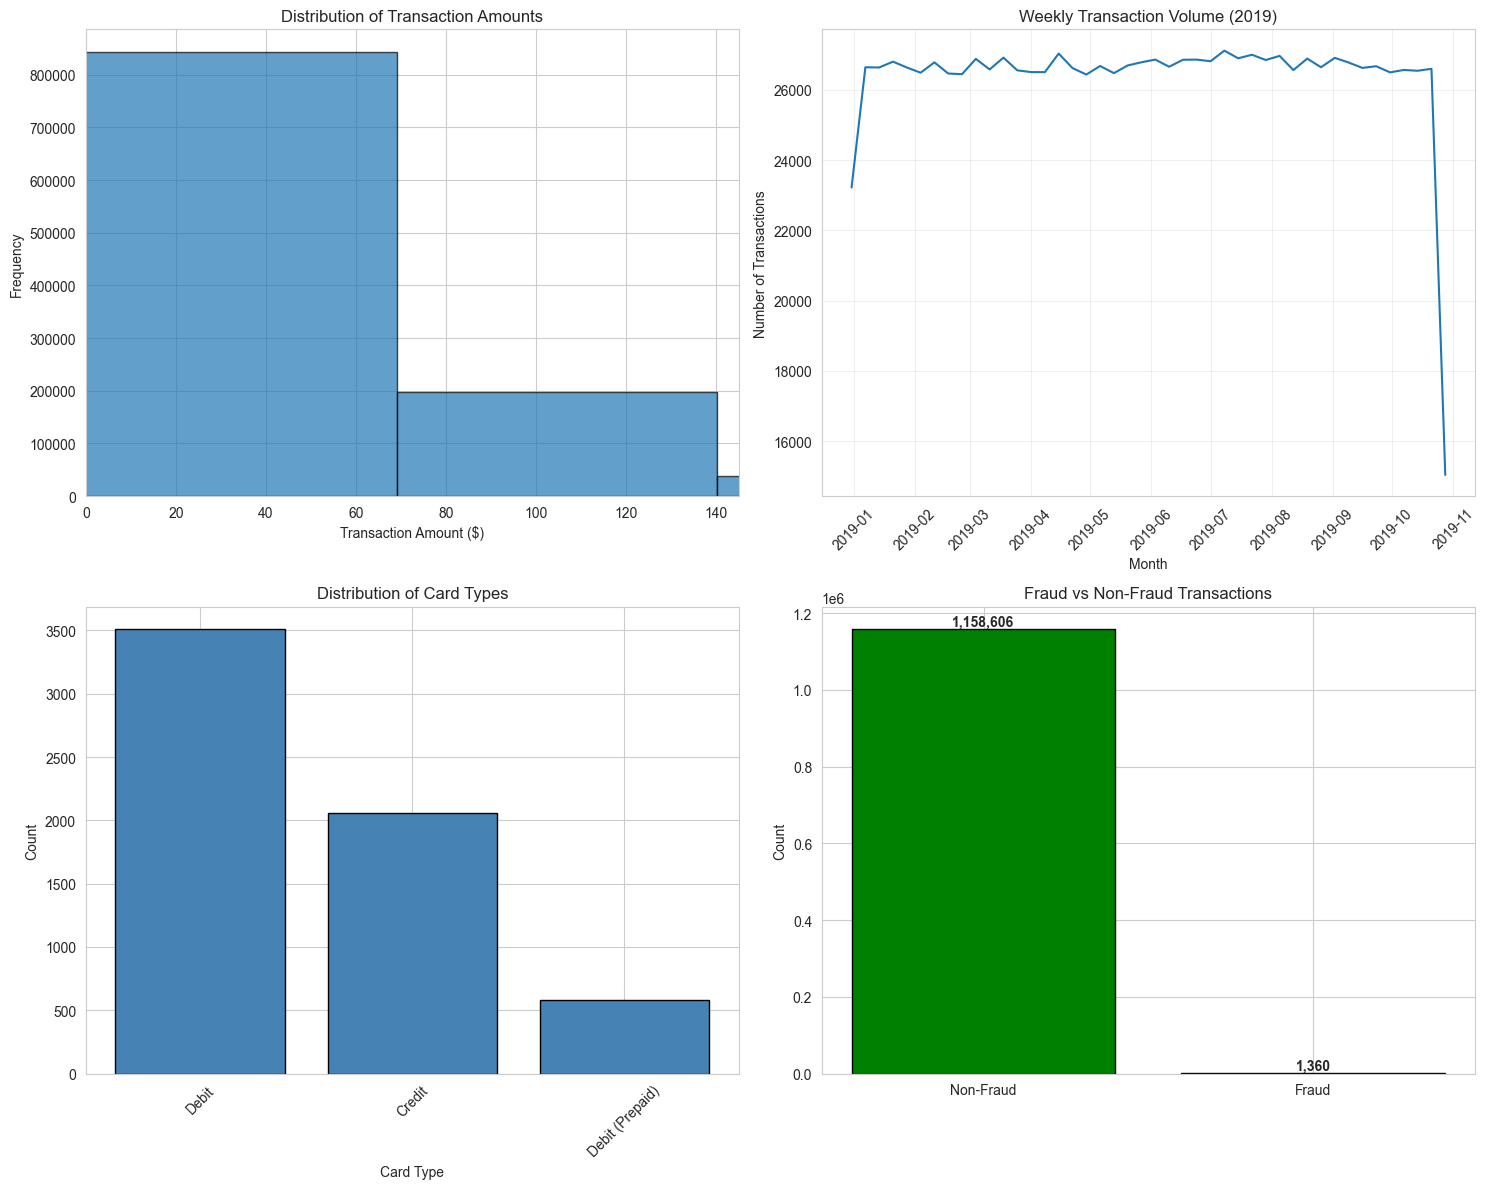

In [346]:
# Overview visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Transaction amount distribution
axes[0, 0].hist(transactions['amount_clean'], bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Transaction Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Transaction Amounts')
axes[0, 0].set_xlim(0, transactions['amount_clean'].quantile(0.95))  # Remove extreme outliers for better visualization

# 2. Transactions over time
# daily_transactions = transactions.groupby(transactions['date'].dt.date).size()
# axes[0, 1].plot(daily_transactions.index, daily_transactions.values, linewidth=1.5)
# axes[0, 1].set_xlabel('Date')
# axes[0, 1].set_ylabel('Number of Transactions')
# axes[0, 1].set_title('Daily Transaction Volume (2019)')
# axes[0, 1].tick_params(axis='x', rotation=45)

weekly_transactions = transactions.groupby(transactions['date'].dt.to_period('W')).size()
weekly_dates = weekly_transactions.index.to_timestamp()

axes[0, 1].plot(weekly_dates, weekly_transactions.values, linewidth=1.5)
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Transactions')
axes[0, 1].set_title('Weekly Transaction Volume (2019)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Format x-axis to show year-month
import matplotlib.dates as mdates
axes[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[0, 1].xaxis.set_major_locator(mdates.MonthLocator())


# 3. Card types distribution
card_type_counts = cards['card_type'].value_counts()
axes[1, 0].bar(card_type_counts.index, card_type_counts.values, color='steelblue', edgecolor='black')
axes[1, 0].set_xlabel('Card Type')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Distribution of Card Types')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Fraud vs Non-Fraud distribution
fraud_counts = transactions_with_fraud['is_fraud'].value_counts()
axes[1, 1].bar(['Non-Fraud', 'Fraud'], fraud_counts.values, color=['green', 'red'], edgecolor='black')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Fraud vs Non-Fraud Transactions')
for i, v in enumerate(fraud_counts.values):
    axes[1, 1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


### 1.4 Target Variable and Key Predictors

**Target Variable:** `is_fraud` - Binary classification (1 = Fraud, 0 = Non-Fraud)

**Key Predictors:**
- Transaction features: amount, merchant details, time, location
- Card features: card type, credit limit, card brand
- User features: demographics, income, credit score, debt


In [347]:
# Analyze target variable distribution
print("TARGET VARIABLE ANALYSIS")
print("=" * 50)
print(f"Total transactions with fraud labels: {transactions_with_fraud['is_fraud'].notna().sum():,}")
print(f"Fraud transactions: {transactions_with_fraud['is_fraud'].sum():,}")
print(f"Non-fraud transactions: {(transactions_with_fraud['is_fraud']==0).sum():,}")
print(f"Fraud rate: {transactions_with_fraud['is_fraud'].mean()*100:.2f}%")
print(f"Missing fraud labels: {transactions_with_fraud['is_fraud'].isna().sum():,}")

# Fraud by card type
fraud_by_card = df_merged.groupby('card_type')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
print("\nFraud Rate by Card Type:")
print(fraud_by_card)


TARGET VARIABLE ANALYSIS
Total transactions with fraud labels: 1,159,966
Fraud transactions: 1,360
Non-fraud transactions: 1,158,606
Fraud rate: 0.12%
Missing fraud labels: 0

Fraud Rate by Card Type:
                 sum   count      mean
card_type                             
Credit           562  353825  0.001588
Debit (Prepaid)   99   78240  0.001265
Debit            699  727901  0.000960


## 2. Univariate Analysis

### 2.1 Numerical Features - Distributions


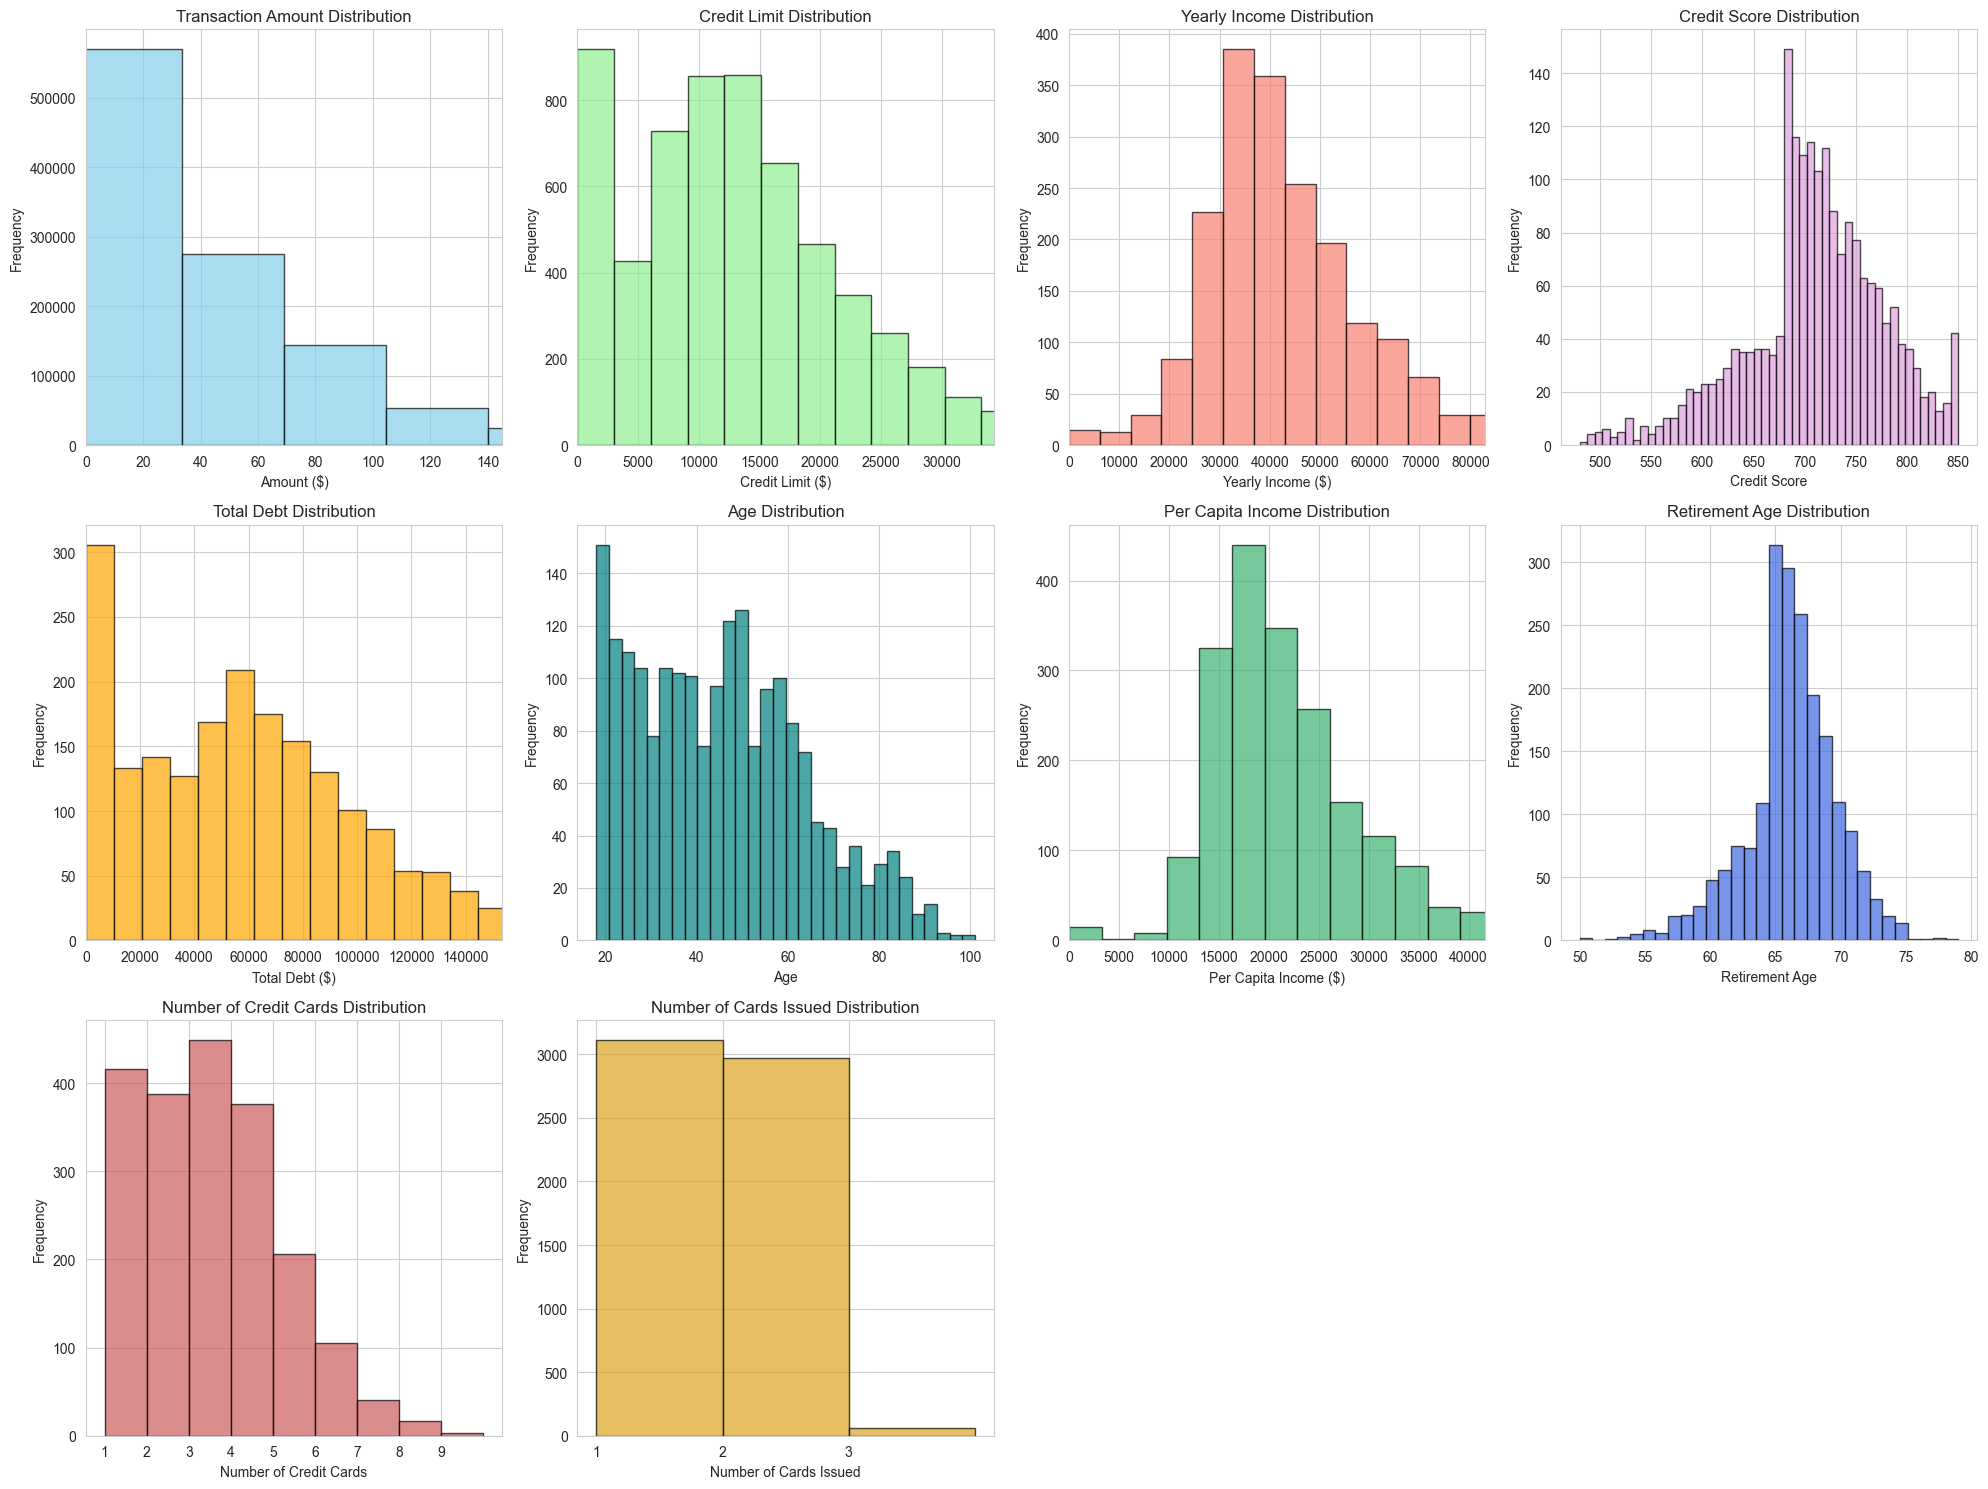

In [348]:
# Histograms for numerical features
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Transaction amount
axes[0, 0].hist(transactions['amount_clean'], bins=200, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Transaction Amount Distribution')
axes[0, 0].set_xlim(0, transactions['amount_clean'].quantile(0.95))

# Credit limit
axes[0, 1].hist(cards['credit_limit_clean'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_xlabel('Credit Limit ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Credit Limit Distribution')
axes[0, 1].set_xlim(0, cards['credit_limit_clean'].quantile(0.95))

# Yearly income
axes[0, 2].hist(users['yearly_income_clean'], bins=50, edgecolor='black', alpha=0.7, color='salmon')
axes[0, 2].set_xlabel('Yearly Income ($)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Yearly Income Distribution')
axes[0, 2].set_xlim(0, users['yearly_income_clean'].quantile(0.95))

# Credit score
axes[0, 3].hist(users['credit_score'], bins=50, edgecolor='black', alpha=0.7, color='plum')
axes[0, 3].set_xlabel('Credit Score')
axes[0, 3].set_ylabel('Frequency')
axes[0, 3].set_title('Credit Score Distribution')

# Total debt
axes[1, 0].hist(users['total_debt_clean'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Total Debt ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Total Debt Distribution')
axes[1, 0].set_xlim(0, users['total_debt_clean'].quantile(0.95))

# Age
axes[1, 1].hist(users['current_age'], bins=30, edgecolor='black', alpha=0.7, color='teal')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Age Distribution')

# Per capita income
axes[1, 2].hist(users['per_capita_income_clean'], bins=50, edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[1, 2].set_xlabel('Per Capita Income ($)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Per Capita Income Distribution')
axes[1, 2].set_xlim(0, users['per_capita_income_clean'].quantile(0.95))

# Retirement age
axes[1, 3].hist(users['retirement_age'], bins=30, edgecolor='black', alpha=0.7, color='royalblue')
axes[1, 3].set_xlabel('Retirement Age')
axes[1, 3].set_ylabel('Frequency')
axes[1, 3].set_title('Retirement Age Distribution')

# Number of credit cards
axes[2, 0].hist(users['num_credit_cards'], bins=range(1, users['num_credit_cards'].max() + 2), edgecolor='black', alpha=0.7, color='indianred')
axes[2, 0].set_xlabel('Number of Credit Cards')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].set_title('Number of Credit Cards Distribution')
axes[2, 0].set_xticks(range(1, users['num_credit_cards'].max() + 1))

# Number of cards issued
axes[2, 1].hist(cards['num_cards_issued'], bins=range(1, cards['num_cards_issued'].max() + 2), edgecolor='black', alpha=0.7, color='goldenrod')
axes[2, 1].set_xlabel('Number of Cards Issued')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].set_title('Number of Cards Issued Distribution')
axes[2, 1].set_xticks(range(1, cards['num_cards_issued'].max() + 1))

# Hide the remaining empty subplots
axes[2, 2].axis('off')
axes[2, 3].axis('off')

plt.tight_layout()
plt.show()

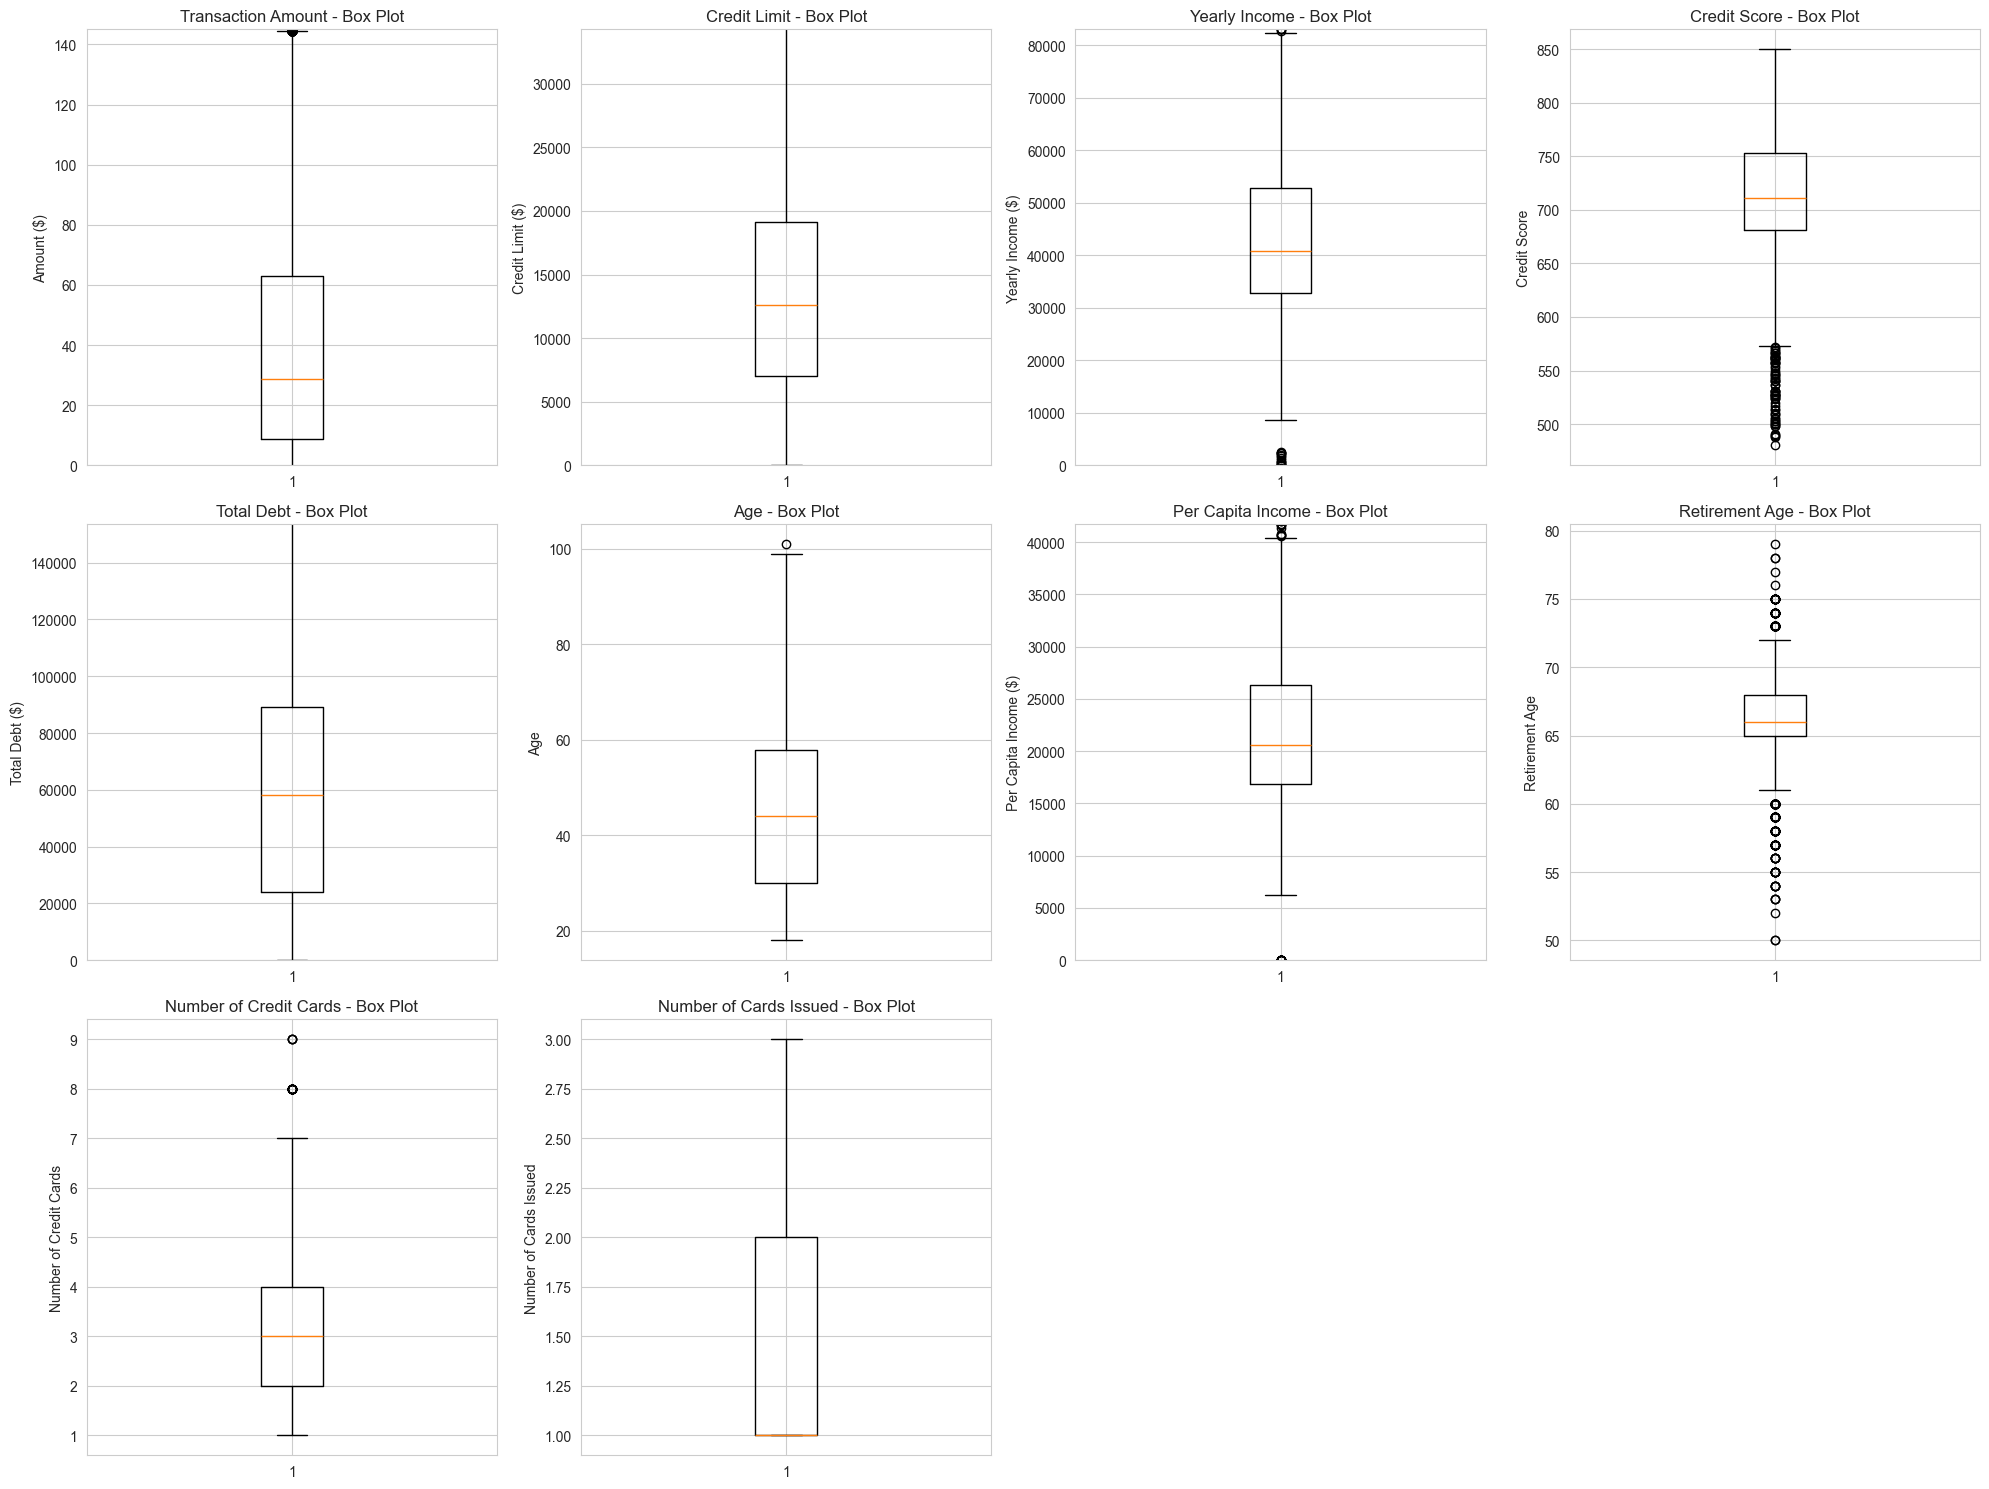

In [349]:
# Box plots for numerical features to identify outliers
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Transaction amount
axes[0, 0].boxplot(transactions['amount_clean'], vert=True)
axes[0, 0].set_ylabel('Amount ($)')
axes[0, 0].set_title('Transaction Amount - Box Plot')
axes[0, 0].set_ylim(0, transactions['amount_clean'].quantile(0.95))

# Credit limit
axes[0, 1].boxplot(cards['credit_limit_clean'], vert=True)
axes[0, 1].set_ylabel('Credit Limit ($)')
axes[0, 1].set_title('Credit Limit - Box Plot')
axes[0, 1].set_ylim(0, cards['credit_limit_clean'].quantile(0.95))

# Yearly income
axes[0, 2].boxplot(users['yearly_income_clean'], vert=True)
axes[0, 2].set_ylabel('Yearly Income ($)')
axes[0, 2].set_title('Yearly Income - Box Plot')
axes[0, 2].set_ylim(0, users['yearly_income_clean'].quantile(0.95))

# Credit score
axes[0, 3].boxplot(users['credit_score'], vert=True)
axes[0, 3].set_ylabel('Credit Score')
axes[0, 3].set_title('Credit Score - Box Plot')

# Total debt
axes[1, 0].boxplot(users['total_debt_clean'], vert=True)
axes[1, 0].set_ylabel('Total Debt ($)')
axes[1, 0].set_title('Total Debt - Box Plot')
axes[1, 0].set_ylim(0, users['total_debt_clean'].quantile(0.95))

# Age
axes[1, 1].boxplot(users['current_age'], vert=True)
axes[1, 1].set_ylabel('Age')
axes[1, 1].set_title('Age - Box Plot')

# Per capita income
axes[1, 2].boxplot(users['per_capita_income_clean'], vert=True)
axes[1, 2].set_ylabel('Per Capita Income ($)')
axes[1, 2].set_title('Per Capita Income - Box Plot')
axes[1, 2].set_ylim(0, users['per_capita_income_clean'].quantile(0.95))

# Retirement age
axes[1, 3].boxplot(users['retirement_age'], vert=True)
axes[1, 3].set_ylabel('Retirement Age')
axes[1, 3].set_title('Retirement Age - Box Plot')

# Number of credit cards
axes[2, 0].boxplot(users['num_credit_cards'], vert=True)
axes[2, 0].set_ylabel('Number of Credit Cards')
axes[2, 0].set_title('Number of Credit Cards - Box Plot')

# Number of cards issued
axes[2, 1].boxplot(cards['num_cards_issued'], vert=True)
axes[2, 1].set_ylabel('Number of Cards Issued')
axes[2, 1].set_title('Number of Cards Issued - Box Plot')

# Hide the remaining empty subplots
axes[2, 2].axis('off')
axes[2, 3].axis('off')

plt.tight_layout()
plt.show()

### 2.2 Categorical Features Analysis


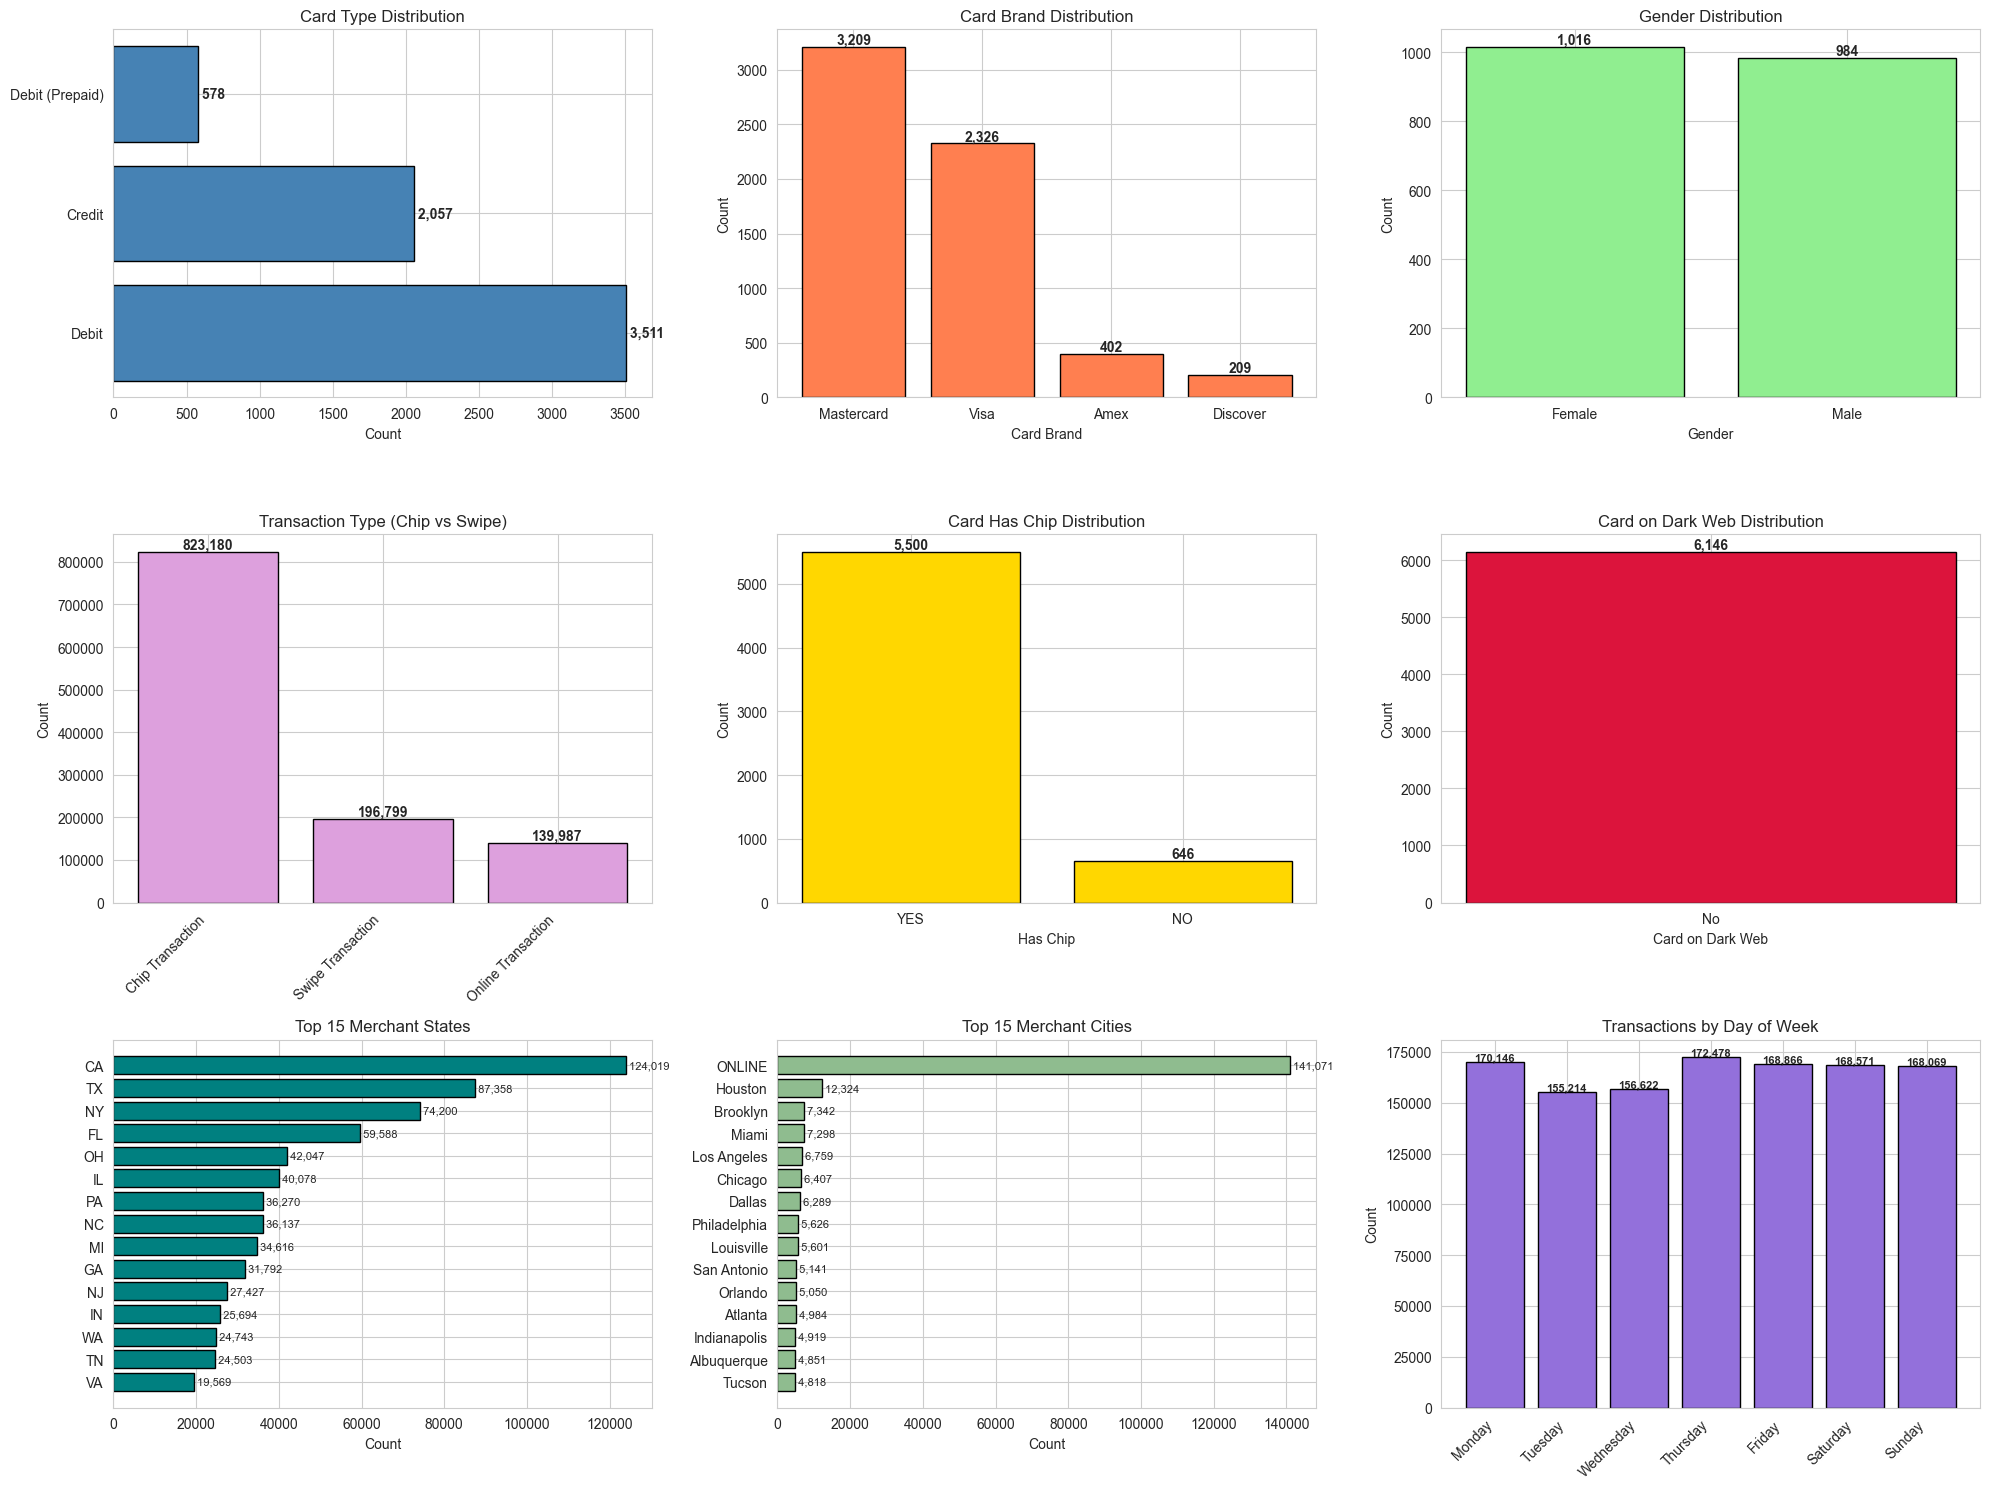

In [350]:
# Categorical features analysis
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Card type
card_type_counts = cards['card_type'].value_counts()
axes[0, 0].barh(card_type_counts.index, card_type_counts.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_title('Card Type Distribution')
for i, v in enumerate(card_type_counts.values):
    axes[0, 0].text(v, i, f' {v:,}', va='center', fontweight='bold')

# Card brand
card_brand_counts = cards['card_brand'].value_counts()
axes[0, 1].bar(card_brand_counts.index, card_brand_counts.values, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Card Brand')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Card Brand Distribution')
for i, v in enumerate(card_brand_counts.values):
    axes[0, 1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Gender
gender_counts = users['gender'].value_counts()
axes[0, 2].bar(gender_counts.index, gender_counts.values, color='lightgreen', edgecolor='black')
axes[0, 2].set_xlabel('Gender')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Gender Distribution')
for i, v in enumerate(gender_counts.values):
    axes[0, 2].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Transaction type (use_chip)
use_chip_counts = transactions['use_chip'].value_counts()
axes[1, 0].bar(range(len(use_chip_counts)), use_chip_counts.values, color='plum', edgecolor='black')
axes[1, 0].set_xticks(range(len(use_chip_counts)))
axes[1, 0].set_xticklabels(use_chip_counts.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Transaction Type (Chip vs Swipe)')
for i, v in enumerate(use_chip_counts.values):
    axes[1, 0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Has chip
has_chip_counts = cards['has_chip'].value_counts()
axes[1, 1].bar(has_chip_counts.index, has_chip_counts.values, color='gold', edgecolor='black')
axes[1, 1].set_xlabel('Has Chip')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Card Has Chip Distribution')
for i, v in enumerate(has_chip_counts.values):
    axes[1, 1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Card on dark web
card_darkweb_counts = cards['card_on_dark_web'].value_counts()
axes[1, 2].bar(card_darkweb_counts.index, card_darkweb_counts.values, color='crimson', edgecolor='black')
axes[1, 2].set_xlabel('Card on Dark Web')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Card on Dark Web Distribution')
for i, v in enumerate(card_darkweb_counts.values):
    axes[1, 2].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Merchant State (Top 15)
merchant_state_counts = transactions['merchant_state'].value_counts().head(15)
axes[2, 0].barh(merchant_state_counts.index, merchant_state_counts.values, color='teal', edgecolor='black')
axes[2, 0].set_xlabel('Count')
axes[2, 0].set_title('Top 15 Merchant States')
axes[2, 0].invert_yaxis()
for i, v in enumerate(merchant_state_counts.values):
    axes[2, 0].text(v, i, f' {v:,}', va='center', fontsize=8)

# Merchant City (Top 15)
merchant_city_counts = transactions['merchant_city'].value_counts().head(15)
axes[2, 1].barh(merchant_city_counts.index, merchant_city_counts.values, color='darkseagreen', edgecolor='black')
axes[2, 1].set_xlabel('Count')
axes[2, 1].set_title('Top 15 Merchant Cities')
axes[2, 1].invert_yaxis()
for i, v in enumerate(merchant_city_counts.values):
    axes[2, 1].text(v, i, f' {v:,}', va='center', fontsize=8)

# Day of Week
day_of_week_counts = transactions['day_of_week'].value_counts()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_ordered = day_of_week_counts.reindex(day_order)
axes[2, 2].bar(range(len(day_of_week_ordered)), day_of_week_ordered.values, color='mediumpurple', edgecolor='black')
axes[2, 2].set_xticks(range(len(day_of_week_ordered)))
axes[2, 2].set_xticklabels(day_of_week_ordered.index, rotation=45, ha='right')
axes[2, 2].set_ylabel('Count')
axes[2, 2].set_title('Transactions by Day of Week')
for i, v in enumerate(day_of_week_ordered.values):
    axes[2, 2].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

In [351]:
# 1. Card Type - Frequency Table
print("1. Card Type:")
print(cards['card_type'].value_counts())
print(f"\nProportions:\n{cards['card_type'].value_counts(normalize=True) * 100}")


1. Card Type:
card_type
Debit              3511
Credit             2057
Debit (Prepaid)     578
Name: count, dtype: int64

Proportions:
card_type
Debit              57.126586
Credit             33.468923
Debit (Prepaid)     9.404491
Name: proportion, dtype: float64


In [352]:
# 2. Card Brand - Frequency Table
print("2. Card Brand:")
print(cards['card_brand'].value_counts())
print(f"\nProportions:\n{cards['card_brand'].value_counts(normalize=True) * 100}")


2. Card Brand:
card_brand
Mastercard    3209
Visa          2326
Amex           402
Discover       209
Name: count, dtype: int64

Proportions:
card_brand
Mastercard    52.212821
Visa          37.845753
Amex           6.540840
Discover       3.400586
Name: proportion, dtype: float64


In [353]:
# 3. Gender - Frequency Table
print("3. Gender:")
print(users['gender'].value_counts())
print(f"\nProportions:\n{users['gender'].value_counts(normalize=True) * 100}")


3. Gender:
gender
Female    1016
Male       984
Name: count, dtype: int64

Proportions:
gender
Female    50.8
Male      49.2
Name: proportion, dtype: float64


In [354]:
# 4. Transaction Type (Chip vs Swipe) - Frequency Table
print("4. Transaction Type (Chip vs Swipe):")
print(transactions['use_chip'].value_counts())
print(f"\nProportions:\n{transactions['use_chip'].value_counts(normalize=True) * 100}")


4. Transaction Type (Chip vs Swipe):
use_chip
Chip Transaction      823180
Swipe Transaction     196799
Online Transaction    139987
Name: count, dtype: int64

Proportions:
use_chip
Chip Transaction      70.965873
Swipe Transaction     16.965928
Online Transaction    12.068199
Name: proportion, dtype: float64


In [355]:
# 5. Day of Week (Transactions) - Frequency Table
print("5. Day of Week (Transactions):")
day_counts = transactions['day_of_week'].value_counts()
print(day_counts)
print(f"\nProportions:\n{(day_counts / day_counts.sum() * 100).round(2)}")


5. Day of Week (Transactions):
day_of_week
Thursday     172478
Monday       170146
Friday       168866
Saturday     168571
Sunday       168069
Wednesday    156622
Tuesday      155214
Name: count, dtype: int64

Proportions:
day_of_week
Thursday     14.87
Monday       14.67
Friday       14.56
Saturday     14.53
Sunday       14.49
Wednesday    13.50
Tuesday      13.38
Name: count, dtype: float64


## 3. Bivariate Analysis

### 3.1 Correlation Matrix


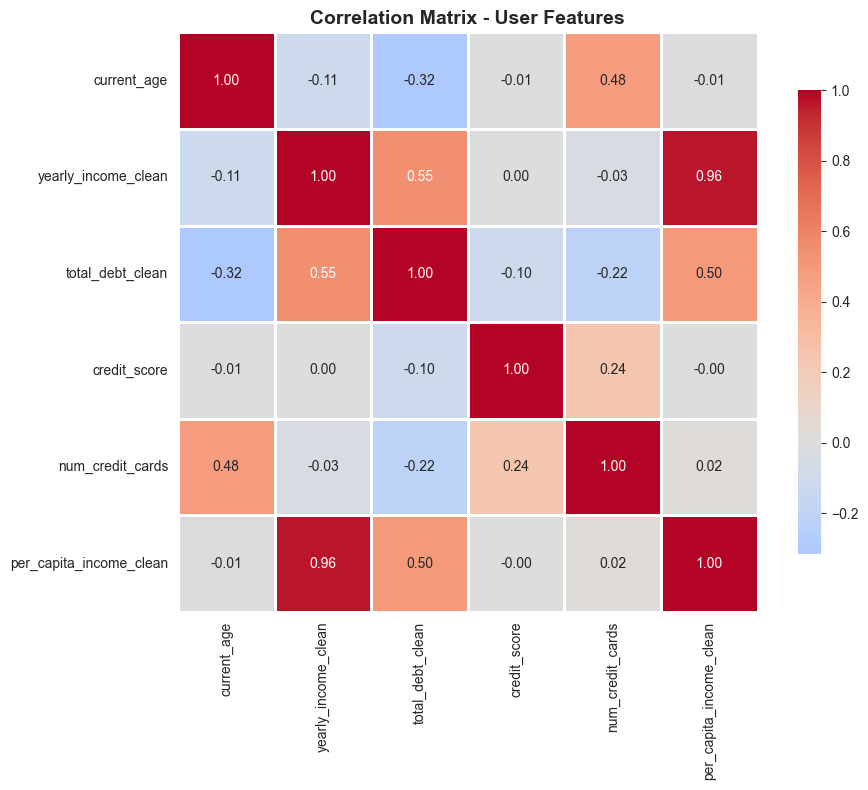


Correlation Matrix - User Features:
                         current_age  yearly_income_clean  total_debt_clean  \
current_age                 1.000000            -0.114316         -0.315443   
yearly_income_clean        -0.114316             1.000000          0.550641   
total_debt_clean           -0.315443             0.550641          1.000000   
credit_score               -0.005468             0.000167         -0.104537   
num_credit_cards            0.484189            -0.032877         -0.217940   
per_capita_income_clean    -0.009054             0.963975          0.496138   

                         credit_score  num_credit_cards  \
current_age                 -0.005468          0.484189   
yearly_income_clean          0.000167         -0.032877   
total_debt_clean            -0.104537         -0.217940   
credit_score                 1.000000          0.237935   
num_credit_cards             0.237935          1.000000   
per_capita_income_clean     -0.004545          0.018606

In [356]:
# Prepare numerical features for correlation analysis
correlation_data = users[['current_age', 'yearly_income_clean', 'total_debt_clean', 
                          'credit_score', 'num_credit_cards', 'per_capita_income_clean']].copy()

# Calculate correlation matrix
corr_matrix = correlation_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - User Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix - User Features:")
print(corr_matrix)


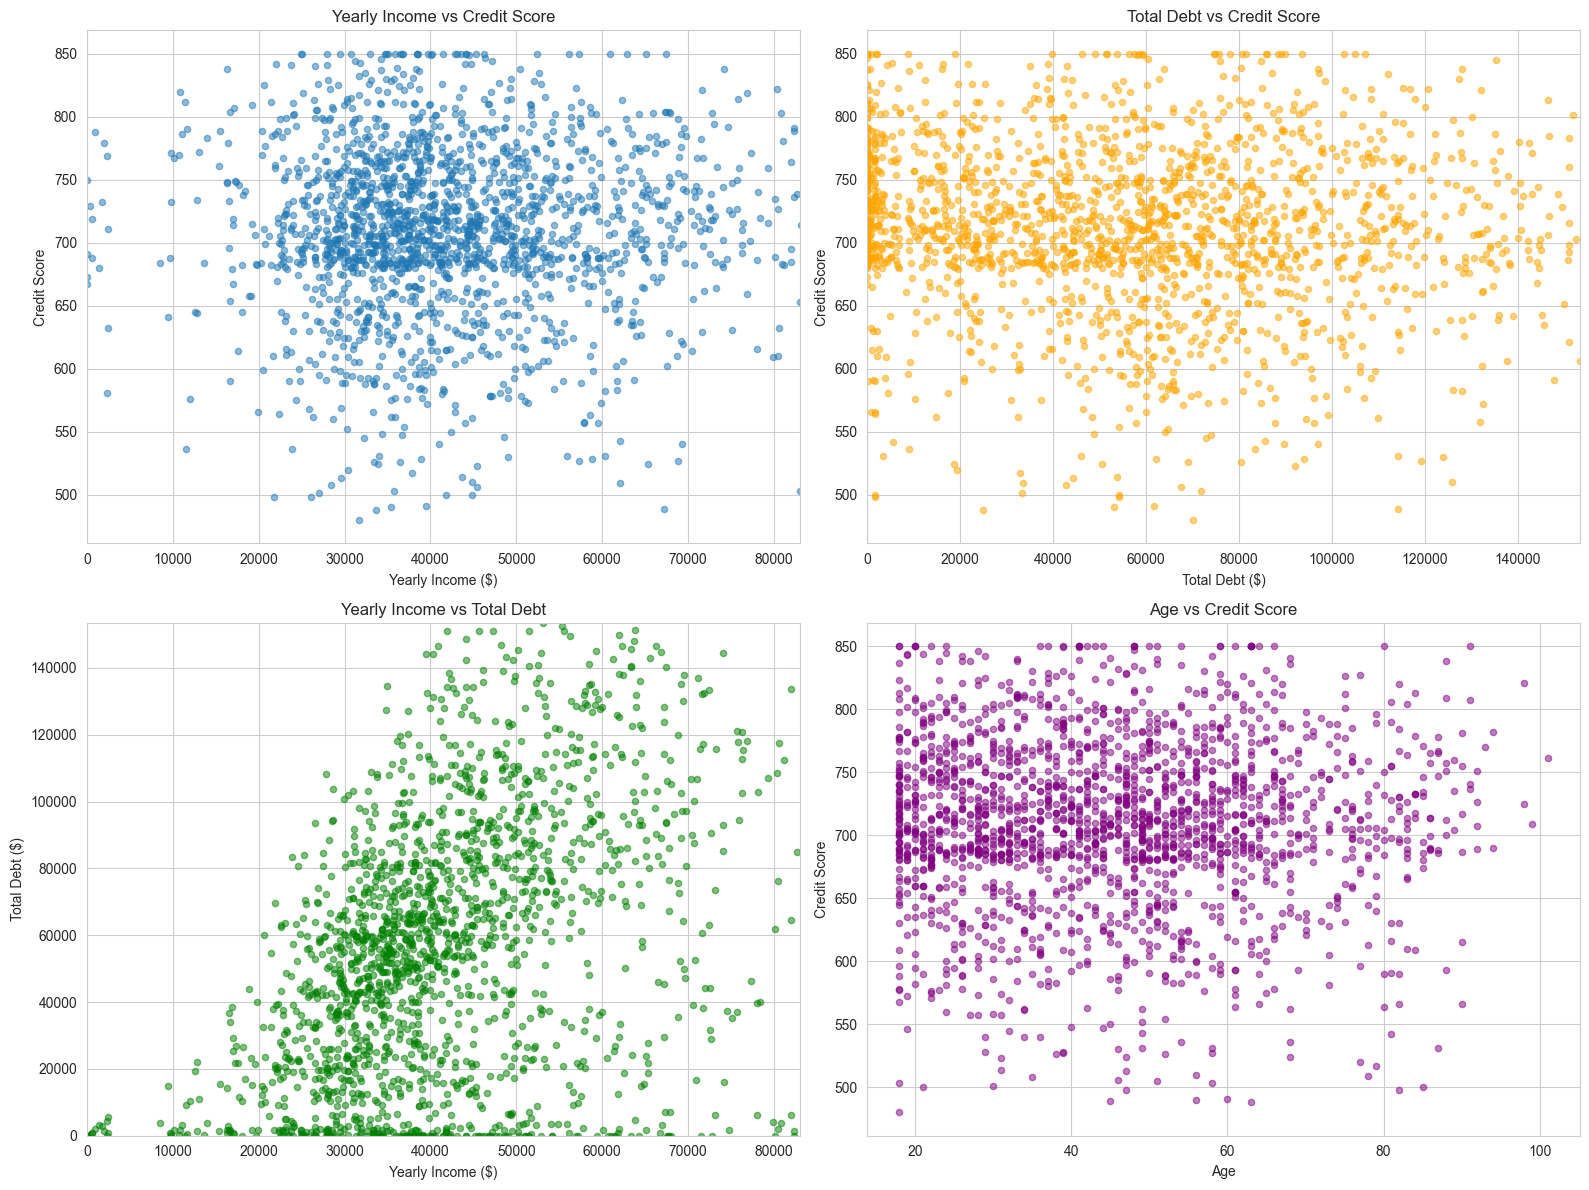

In [357]:
# Scatter plots for key relationships
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Yearly income vs Credit score
axes[0, 0].scatter(users['yearly_income_clean'], users['credit_score'], alpha=0.5, s=20)
axes[0, 0].set_xlabel('Yearly Income ($)')
axes[0, 0].set_ylabel('Credit Score')
axes[0, 0].set_title('Yearly Income vs Credit Score')
axes[0, 0].set_xlim(0, users['yearly_income_clean'].quantile(0.95))

# Total debt vs Credit score
axes[0, 1].scatter(users['total_debt_clean'], users['credit_score'], alpha=0.5, s=20, color='orange')
axes[0, 1].set_xlabel('Total Debt ($)')
axes[0, 1].set_ylabel('Credit Score')
axes[0, 1].set_title('Total Debt vs Credit Score')
axes[0, 1].set_xlim(0, users['total_debt_clean'].quantile(0.95))

# Yearly income vs Total debt
axes[1, 0].scatter(users['yearly_income_clean'], users['total_debt_clean'], alpha=0.5, s=20, color='green')
axes[1, 0].set_xlabel('Yearly Income ($)')
axes[1, 0].set_ylabel('Total Debt ($)')
axes[1, 0].set_title('Yearly Income vs Total Debt')
axes[1, 0].set_xlim(0, users['yearly_income_clean'].quantile(0.95))
axes[1, 0].set_ylim(0, users['total_debt_clean'].quantile(0.95))

# Age vs Credit score
axes[1, 1].scatter(users['current_age'], users['credit_score'], alpha=0.5, s=20, color='purple')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Credit Score')
axes[1, 1].set_title('Age vs Credit Score')

plt.tight_layout()
plt.show()


### 3.3 Grouped Summaries


In [358]:
# Prepare data for grouped summaries
# Create amount_clean in df_merged if it doesn't exist
if 'amount_clean' not in df_merged.columns:
    # Clean the amount column (remove $ and commas, convert to float)
    df_merged['amount_clean'] = df_merged['amount'].str.replace('$', '').str.replace(',', '').astype(float)

# Create date-related columns in df_merged if they don't exist
if 'day_of_week' not in df_merged.columns or 'hour' not in df_merged.columns:
    # Convert date to datetime if not already
    if df_merged['date'].dtype == 'object':
        df_merged['date'] = pd.to_datetime(df_merged['date'])
    # Extract date features
    if 'day_of_week' not in df_merged.columns:
        df_merged['day_of_week'] = df_merged['date'].dt.day_name()
    if 'hour' not in df_merged.columns:
        df_merged['hour'] = df_merged['date'].dt.hour

print("Data prepared for grouped summaries.")


Data prepared for grouped summaries.


In [359]:
# 1. Average Transaction Amount by Card Type
print("1. Average Transaction Amount by Card Type:")
avg_amount_by_card = df_merged.groupby('card_type')['amount_clean'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
print(avg_amount_by_card)


1. Average Transaction Amount by Card Type:
                      mean  median   count
card_type                                 
Credit           54.741239   39.09  353825
Debit            39.029538   26.69  727901
Debit (Prepaid)  21.684517   17.30   78240


In [360]:
# 2. Average Transaction Amount by Card Brand
print("2. Average Transaction Amount by Card Brand:")
avg_amount_by_brand = df_merged.groupby('card_brand')['amount_clean'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
print(avg_amount_by_brand)


2. Average Transaction Amount by Card Brand:
                 mean  median   count
card_brand                           
Amex        55.088928   39.00   72733
Discover    54.715532   37.85   29722
Visa        43.786886   29.81  431822
Mastercard  39.850272   26.85  625689


In [361]:
# 3. Fraud Rate by Card Type
print("3. Fraud Rate by Card Type:")
fraud_by_card_type = df_merged.groupby('card_type')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
fraud_by_card_type.columns = ['Fraud_Count', 'Total_Count', 'Fraud_Rate']
fraud_by_card_type['Fraud_Rate_Pct'] = fraud_by_card_type['Fraud_Rate'] * 100
print(fraud_by_card_type)


3. Fraud Rate by Card Type:


                 Fraud_Count  Total_Count  Fraud_Rate  Fraud_Rate_Pct
card_type                                                            
Credit                   562       353825    0.001588        0.158836
Debit (Prepaid)           99        78240    0.001265        0.126534
Debit                    699       727901    0.000960        0.096030


In [362]:
# 4. Average Transaction Amount by Day of Week
print("4. Average Transaction Amount by Day of Week:")
avg_amount_by_day = df_merged.groupby('day_of_week')['amount_clean'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
print(avg_amount_by_day)


4. Average Transaction Amount by Day of Week:
                  mean  median   count
day_of_week                           
Tuesday      45.408576   31.56  155214
Monday       44.167615   28.27  170146
Wednesday    42.898827   31.97  156622
Sunday       41.944128   27.86  168069
Saturday     41.739301   27.64  168571
Friday       41.559447   27.67  168866
Thursday     41.104630   27.23  172478


In [363]:
# 5. Average Transaction Amount by Hour of Day
print("5. Average Transaction Amount by Hour of Day:")
avg_amount_by_hour = df_merged.groupby('hour')['amount_clean'].agg(['mean', 'median', 'count'])
print(avg_amount_by_hour)


5. Average Transaction Amount by Hour of Day:
           mean  median  count
hour                          
0     48.065920  34.125  12552
1     58.473141  35.895  10086
2     48.776362  28.320   9713
3     54.163317  36.505   9136
4     53.677255  40.355  10084
5     45.368856  27.470  15875
6     33.978948  17.470  66682
7     32.751506  20.420  78238
8     34.852432  18.840  77025
9     33.514636  16.450  76797
10    37.781651  18.310  75446
11    39.812573  20.770  82819
12    39.438582  21.180  83184
13    43.422354  28.790  77985
14    47.270097  36.750  77054
15    46.100027  35.240  74515
16    46.512443  34.530  75461
17    50.105732  39.670  41760
18    49.890590  39.000  41195
19    48.978676  40.890  39690
20    51.811635  39.460  37165
21    50.143832  40.000  37303
22    50.917726  39.150  36187
23    59.442110  38.495  14014


In [364]:
# 6. Credit Score Statistics by Gender
print("6. Credit Score Statistics by Gender:")
credit_by_gender = users.groupby('gender')['credit_score'].agg(['mean', 'median', 'std', 'count'])
print(credit_by_gender)


6. Credit Score Statistics by Gender:
              mean  median        std  count
gender                                      
Female  709.172244   710.0  67.599858   1016
Male    710.315041   712.0  66.858913    984


In [365]:
# 7. Yearly Income Statistics by Gender
print("7. Yearly Income Statistics by Gender:")
income_by_gender = users.groupby('gender')['yearly_income_clean'].agg(['mean', 'median', 'std', 'count'])
print(income_by_gender)


7. Yearly Income Statistics by Gender:
                mean   median           std  count
gender                                            
Female  46048.314961  40857.5  24709.174135   1016
Male    45372.638211  40500.0  21081.212529    984


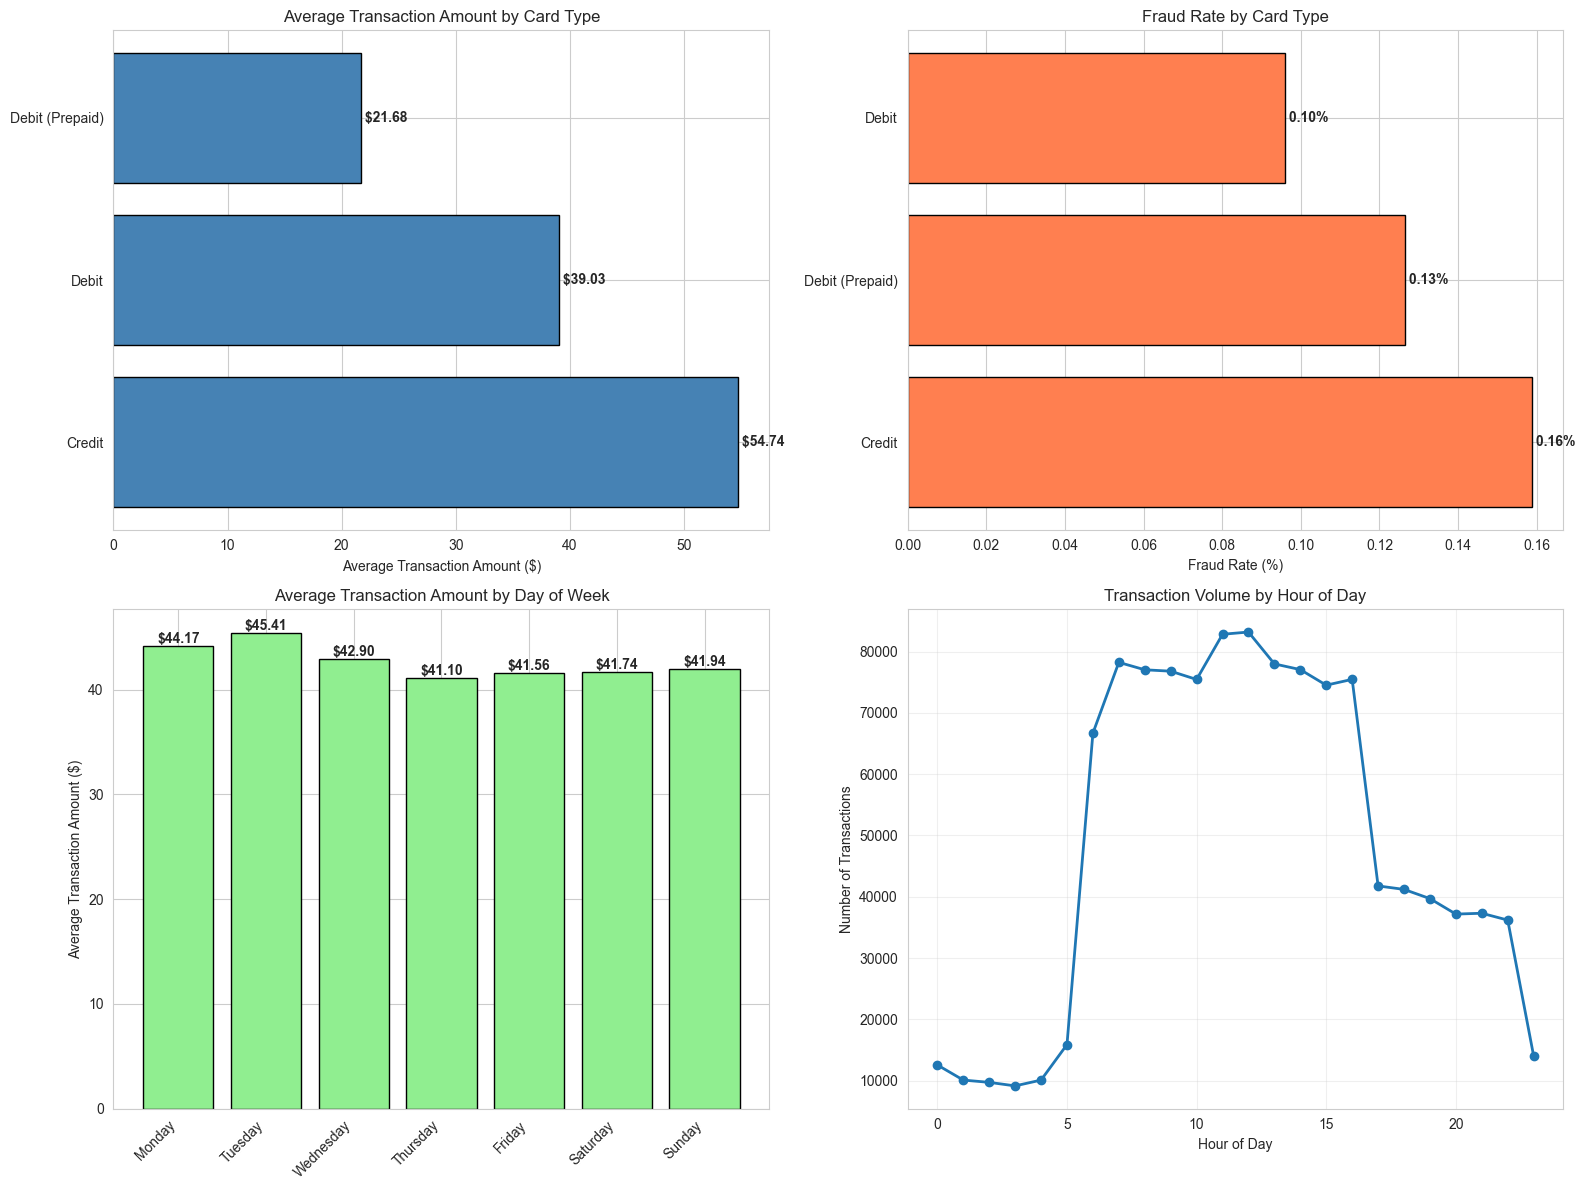

In [366]:
# Visualize grouped summaries
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Average transaction amount by card type
avg_by_card = df_merged.groupby('card_type')['amount_clean'].mean().sort_values(ascending=False)
axes[0, 0].barh(avg_by_card.index, avg_by_card.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Average Transaction Amount ($)')
axes[0, 0].set_title('Average Transaction Amount by Card Type')
for i, v in enumerate(avg_by_card.values):
    axes[0, 0].text(v, i, f' ${v:.2f}', va='center', fontweight='bold')

# Fraud rate by card type
fraud_rate_by_card = df_merged.groupby('card_type')['is_fraud'].mean().sort_values(ascending=False) * 100
axes[0, 1].barh(fraud_rate_by_card.index, fraud_rate_by_card.values, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Fraud Rate (%)')
axes[0, 1].set_title('Fraud Rate by Card Type')
for i, v in enumerate(fraud_rate_by_card.values):
    axes[0, 1].text(v, i, f' {v:.2f}%', va='center', fontweight='bold')

# Average transaction amount by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_by_day = df_merged.groupby('day_of_week')['amount_clean'].mean().reindex(day_order)
axes[1, 0].bar(range(len(avg_by_day)), avg_by_day.values, color='lightgreen', edgecolor='black')
axes[1, 0].set_xticks(range(len(avg_by_day)))
axes[1, 0].set_xticklabels(avg_by_day.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Average Transaction Amount ($)')
axes[1, 0].set_title('Average Transaction Amount by Day of Week')
for i, v in enumerate(avg_by_day.values):
    axes[1, 0].text(i, v, f'${v:.2f}', ha='center', va='bottom', fontweight='bold')

# Transactions by hour
trans_by_hour = df_merged.groupby('hour').size()
axes[1, 1].plot(trans_by_hour.index, trans_by_hour.values, marker='o', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Number of Transactions')
axes[1, 1].set_title('Transaction Volume by Hour of Day')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Insights

Based on the exploratory data analysis, here are the key patterns and anomalies identified:


### Insight 1: Imbalanced Fraud Distribution

The dataset shows a significant class imbalance in fraud detection. Only a small percentage of transactions are labeled as fraudulent, which is typical for real-world fraud detection scenarios. This imbalance will require special attention during modeling, such as using techniques like SMOTE, class weighting, or stratified sampling to ensure the model can effectively learn to identify fraudulent transactions.

**Implications:**
- Standard accuracy metrics may be misleading; precision, recall, and F1-score will be more appropriate
- The model may have a bias toward predicting non-fraudulent transactions
- Cost-sensitive learning approaches may be necessary to minimize false negatives (missed fraud)


### Insight 2: Card Type and Fraud Risk Correlation

Different card types show varying fraud rates. Credit cards and certain debit card types may exhibit different fraud patterns. This suggests that card type is a significant predictor of fraud risk and should be carefully considered in the modeling process.

**Implications:**
- Card type should be a key feature in fraud prediction models
- Different fraud detection strategies may be needed for different card types
- Business rules or separate models for different card types could improve performance


### Insight 3: Temporal Patterns in Transactions

The analysis reveals distinct temporal patterns in transaction behavior, including variations by day of week and hour of day. These patterns could indicate normal vs. anomalous behavior, as fraudulent transactions may occur at unusual times or follow different temporal distributions compared to legitimate transactions.

**Implications:**
- Time-based features (hour, day of week, month) are important for fraud detection
- Anomalies in transaction timing could be strong indicators of fraud
- Real-time fraud detection systems should incorporate temporal context


In [367]:
# Additional analysis to support insights
print("ADDITIONAL ANALYSIS FOR INSIGHTS")
print("=" * 60)

# Insight 1: Fraud distribution details
print("\nInsight 1 - Fraud Distribution:")
print(f"Total transactions: {len(transactions_with_fraud):,}")
print(f"Transactions with fraud labels: {transactions_with_fraud['is_fraud'].notna().sum():,}")
print(f"Fraud transactions: {transactions_with_fraud['is_fraud'].sum():,}")
print(f"Non-fraud transactions: {(transactions_with_fraud['is_fraud']==0).sum():,}")
if transactions_with_fraud['is_fraud'].notna().sum() > 0:
    print(f"Fraud rate: {(transactions_with_fraud['is_fraud'].sum() / transactions_with_fraud['is_fraud'].notna().sum() * 100):.2f}%")

# Insight 2: Fraud by card type
print("\n" + "=" * 60)
print("\nInsight 2 - Fraud Rate by Card Type:")
fraud_card_analysis = df_merged.groupby('card_type')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
fraud_card_analysis.columns = ['Fraud_Count', 'Total_Count', 'Fraud_Rate']
fraud_card_analysis['Fraud_Rate_Pct'] = fraud_card_analysis['Fraud_Rate'] * 100
print(fraud_card_analysis)

# Insight 3: Temporal patterns
print("\n" + "=" * 60)
print("\nInsight 3 - Transaction Patterns by Hour:")
hourly_patterns = df_merged.groupby('hour').agg({
    'amount_clean': ['mean', 'count'],
    'is_fraud': 'mean'
}).round(2)
print(hourly_patterns.head(10))

print("\nTransaction Patterns by Day of Week:")
daily_patterns = df_merged.groupby('day_of_week').agg({
    'amount_clean': ['mean', 'count'],
    'is_fraud': 'mean'
}).round(2)
print(daily_patterns)


ADDITIONAL ANALYSIS FOR INSIGHTS

Insight 1 - Fraud Distribution:
Total transactions: 1,159,966
Transactions with fraud labels: 1,159,966
Fraud transactions: 1,360
Non-fraud transactions: 1,158,606
Fraud rate: 0.12%


Insight 2 - Fraud Rate by Card Type:
                 Fraud_Count  Total_Count  Fraud_Rate  Fraud_Rate_Pct
card_type                                                            
Credit                   562       353825    0.001588        0.158836
Debit (Prepaid)           99        78240    0.001265        0.126534
Debit                    699       727901    0.000960        0.096030


Insight 3 - Transaction Patterns by Hour:
     amount_clean        is_fraud
             mean  count     mean
hour                             
0           48.07  12552      0.0
1           58.47  10086      0.0
2           48.78   9713      0.0
3           54.16   9136      0.0
4           53.68  10084      0.0
5           45.37  15875      0.0
6           33.98  66682      0.0
7          